## Basic Bayesian Poisson Regression and Prediction
### Alex Bass

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import os
import bambi as bmb

from formulae import design_matrices

In [2]:
data data = pd.read_csv('/Users/alex/Library/CloudStorage/OneDrive-Personal/DS6040/Project - School Shootings/Finalized_Data/train.csv') #reading in final data
data.columns= pd.read_csv('/Users/alex/Library/CloudStorage/OneDrive-Personal/DS6040/Project - School Shootings/Finalized_Data/train.csv') #reading in final data
data.columns

Index(['STATE', 'gun_own', 'hunt_license', 'background_checks',
       'gun_permit_law', 'under40', 'Male', 'White', 'Black', 'Asian',
       'Hispanic', 'Unemployment_rate_2021', 'Median_Household_Income_2020',
       'ba_plus', 'less_than_hs', 'hs', 'some_col', 'population', 'n',
       'gun_strictness', 'rural', 'suburban', 'urban'],
      dtype='object')

In [3]:
data.dropna(inplace = True) #dropping NAs

In [4]:
#scaling all data
columns_to_scale = ['gun_own',
       'hunt_license', 'under40', 'Male', 'White', 'Black', 'Asian',
       'Hispanic', 'Unemployment_rate_2021', 'Median_Household_Income_2020',
       'ba_plus', 'less_than_hs', 'hs', 'some_col',
       'population', 'n', 'gun_strictness']

data[columns_to_scale] = data[columns_to_scale].apply(lambda x : (x - np.mean(x))/np.std(x))

In [5]:
fml = "n ~ gun_own + hunt_license + background_checks + gun_permit_law + under40 + Male + White + Black + Asian + Hispanic + Unemployment_rate_2021 + Median_Household_Income_2020 + ba_plus + less_than_hs + hs + some_col + urban + suburban + rural + population + gun_strictness"  # full formulae formulation

dm = design_matrices(fml, data, na_action="error")

mx_ex = dm.common.as_dataframe()
mx_en = dm.response.as_dataframe()

mx_ex

,Intercept,gun_own,hunt_license,background_checks,gun_permit_law,under40,Male,White,Black,Asian,...,Median_Household_Income_2020,ba_plus,less_than_hs,hs,some_col,urban,suburban,rural,population,gun_strictness
0,1.0,0.833042,-0.186645,0.0,0.0,0.397307,-0.717680,-0.495257,0.745100,-0.136231,...,0.694312,0.589642,-0.184500,-0.346835,-0.382626,1.0,0.0,0.0,-0.145751,-1.154567
1,1.0,0.833042,-0.186645,0.0,0.0,-0.419029,-0.718403,0.187723,-0.039755,-0.172758,...,0.939418,0.960109,-0.475586,-0.917436,0.061710,1.0,0.0,0.0,0.355878,-1.154567
2,1.0,0.833042,-0.186645,0.0,0.0,0.204220,1.238609,-2.151528,2.691732,-0.374357,...,-1.276080,-1.134098,2.131007,0.245205,-0.690082,0.0,1.0,0.0,-0.239213,-1.154567
3,1.0,0.833042,-0.186645,0.0,0.0,0.386655,1.392354,-0.464478,0.825132,-0.460765,...,-0.449379,-1.161714,1.112068,1.511475,-1.235287,1.0,0.0,0.0,-0.246082,-1.154567
4,1.0,0.833042,-0.186645,0.0,0.0,0.074468,-0.388431,0.699984,-0.530321,-0.425066,...,-0.154428,-0.965131,0.790681,0.158194,0.638844,1.0,0.0,0.0,-0.139885,-1.154567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3136,1.0,2.206241,1.079379,0.0,0.0,1.234813,0.612461,0.573391,-0.549638,-0.171511,...,0.901519,-0.143786,-0.823092,-0.224346,1.501087,0.0,1.0,0.0,-0.186291,-2.055884
3137,1.0,2.206241,1.079379,0.0,0.0,0.661028,0.720313,0.648044,-0.596664,0.035955,...,2.405455,3.348400,-1.173494,-2.484783,-1.319654,0.0,0.0,1.0,-0.242875,-2.055884
3138,1.0,2.206241,1.079379,0.0,0.0,0.884406,0.190871,0.668374,-0.595385,-0.366069,...,0.947039,-0.361401,-0.911429,0.505643,0.988468,0.0,0.0,1.0,-0.252580,-2.055884
3139,1.0,2.206241,1.079379,0.0,0.0,-0.643928,0.290855,0.620004,-0.608385,-0.255988,...,0.074132,0.124250,-0.729335,-0.699993,1.565122,0.0,0.0,1.0,-0.289808,-2.055884


In [64]:
quick_prior_change = 10

with pm.Model() as mdl_fish:

    # define priors, weakly informative Normal
    b0 = pm.Normal("Intercept", mu=0, sigma=quick_prior_change)
    b1 = pm.Normal("background_checks", mu=0, sigma=quick_prior_change)#pm.Bernoulli("background_checks", p=Bernoulli_prior)
    b2 = pm.Normal("gun_permit_law", mu=0, sigma=quick_prior_change)
    b3 = pm.Normal("under40", mu=0, sigma=quick_prior_change)
    b4 = pm.Normal("Male", mu=0, sigma=quick_prior_change)
    b5 = pm.Normal("White", mu=0, sigma=quick_prior_change)
    b6 = pm.Normal("Black", mu=0, sigma=quick_prior_change)
    b7 = pm.Normal("Asian", mu=0, sigma=quick_prior_change)
    b8 = pm.Normal("Hispanic", mu=0, sigma=quick_prior_change)
    b9 = pm.Normal("Unemployment_rate_2021", mu=0, sigma=quick_prior_change)
    b10 = pm.Normal("Median_Household_Income_2020", mu=0, sigma=quick_prior_change)
    b11 = pm.Normal("ba_plus", mu=0, sigma=quick_prior_change)
    b12 = pm.Normal("less_than_hs", mu=0, sigma=quick_prior_change)
    b13 = pm.Normal("hs", mu=0, sigma=quick_prior_change)
    b14 = pm.Normal("some_col", mu=0, sigma=quick_prior_change)
    b15 = pm.Normal("population", mu=0, sigma=quick_prior_change)
    b16 = pm.Normal("gun_strictness", mu=0, sigma=quick_prior_change)
    #b17 = pm.Normal("urban", mu=0, sigma=quick_prior_change)
    #b18 = pm.Normal("suburban", mu=0, sigma=quick_prior_change)
    #b19 = pm.Normal("rural", mu=0, sigma=quick_prior_change)

    # define linear model and exp link function
    theta = (
        b0
        + b1 * mx_ex["background_checks"].values
        + b2 * mx_ex["gun_permit_law"].values
        + b3 * mx_ex["under40"].values
        + b4 * mx_ex["Male"].values
        + b5 * mx_ex["White"].values
        + b6 * mx_ex["Black"].values
        + b7 * mx_ex["Asian"].values
        + b8 * mx_ex["Hispanic"].values
        + b9 * mx_ex["Unemployment_rate_2021"].values
        + b10 * mx_ex["Median_Household_Income_2020"].values
        + b11 * mx_ex["ba_plus"].values
        + b12 * mx_ex["less_than_hs"].values
        + b13 * mx_ex["hs"].values
        + b14 * mx_ex["some_col"].values
        + b15 * mx_ex["population"].values
        + b16 * mx_ex["gun_strictness"].values
        #+ b17 * mx_ex["urban"].values
        #+ b18 * mx_ex["suburban"].values
        #+ b19 * mx_ex["rural"].values
    )

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=pm.math.exp(theta), observed=mx_en["n"].values)

In [67]:
with mdl_fish:
    inf_fish = pm.sample(1000, tune=1000)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gun_strictness, population, some_col, hs, less_than_hs, ba_plus, Median_Household_Income_2020, Unemployment_rate_2021, Hispanic, Asian, Black, White, Male, under40, gun_permit_law, background_checks, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 471 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8814061000018926, but should be close to 0.8. Try to increase the number of tuning steps.
There were 79 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


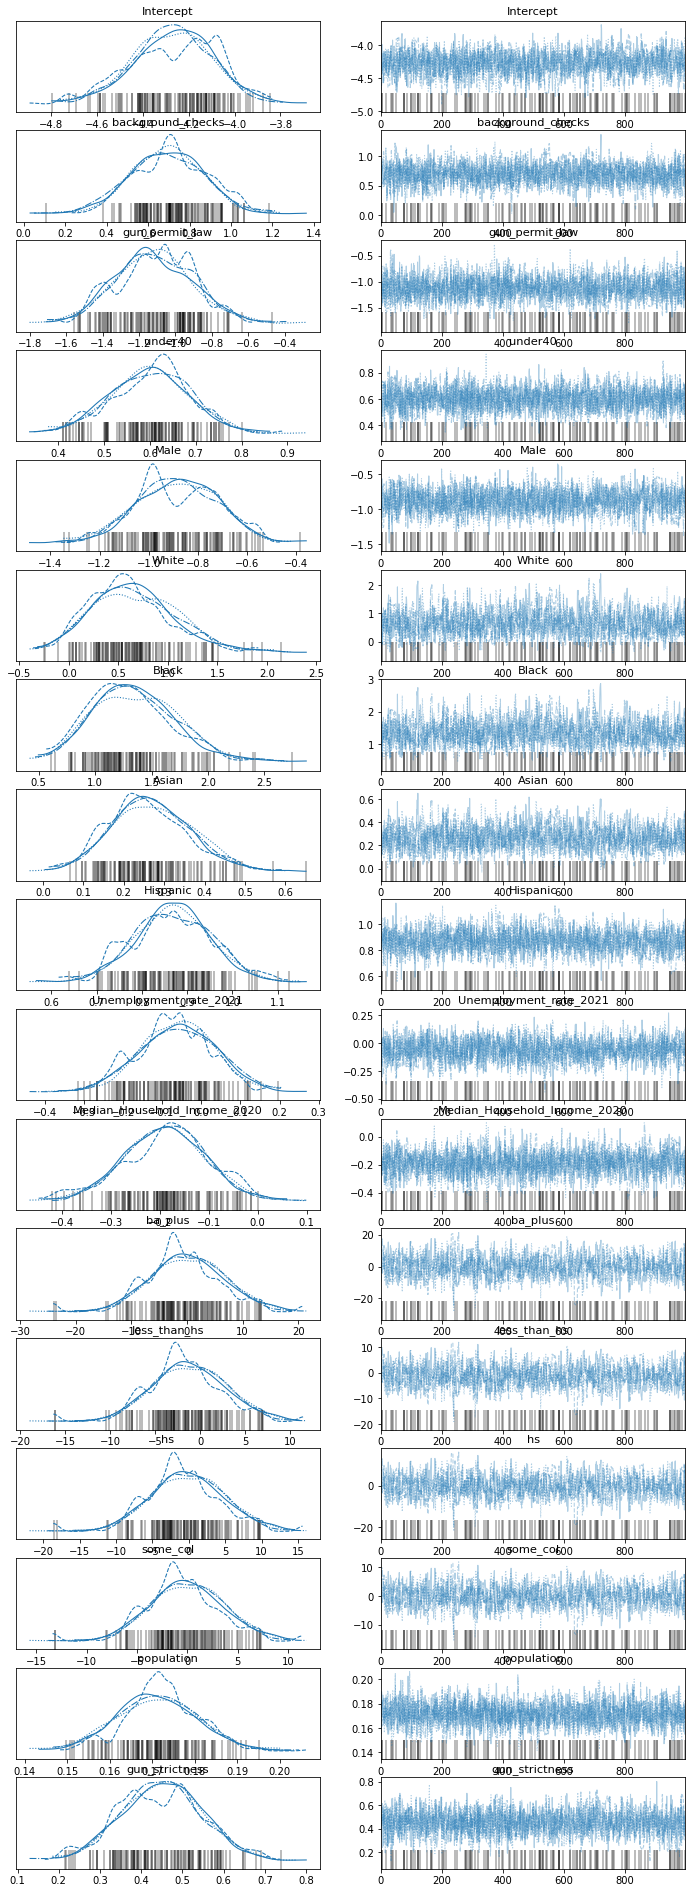

In [68]:
az.plot_trace(inf_fish);

In [71]:
az.summary(inf_fish, kind="stats") # these need to be exponentiated to be interpretted !!

Got error No model on context stack. trying to find log_likelihood in translation.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%
Intercept,-4.267,0.176,-4.618,-3.954
background_checks,0.696,0.175,0.362,1.011
gun_permit_law,-1.114,0.212,-1.475,-0.692
under40,0.601,0.085,0.439,0.756
Male,-0.883,0.164,-1.162,-0.559
White,0.649,0.432,-0.157,1.419
Black,1.346,0.377,0.691,2.058
Asian,0.268,0.101,0.090,0.467
Hispanic,0.869,0.086,0.708,1.025
Unemployment_rate_2021,-0.063,0.096,-0.235,0.121


In [11]:
model = bmb.Model(fml, data, family="poisson")

In [17]:
inf_fish_alt = model.fit(draws=1000, tune=1000, target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, gun_own, hunt_license, background_checks, gun_permit_law, under40, Male, White, Black, Asian, Hispanic, Unemployment_rate_2021, Median_Household_Income_2020, ba_plus, less_than_hs, hs, some_col, urban, suburban, rural, population, gun_strictness]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 682 seconds.


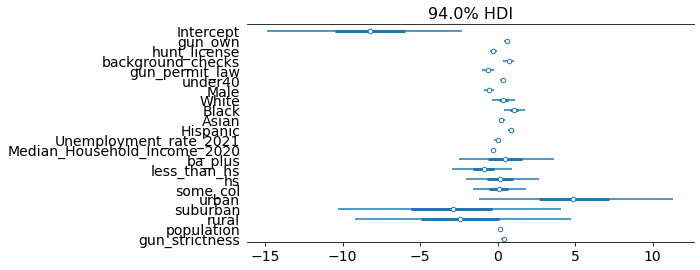

In [18]:
az.plot_forest(
    inf_fish_alt,
    combined=True,
    figsize=(8, 4)
);

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (22), generating only 20 plots
  warnings.warn(


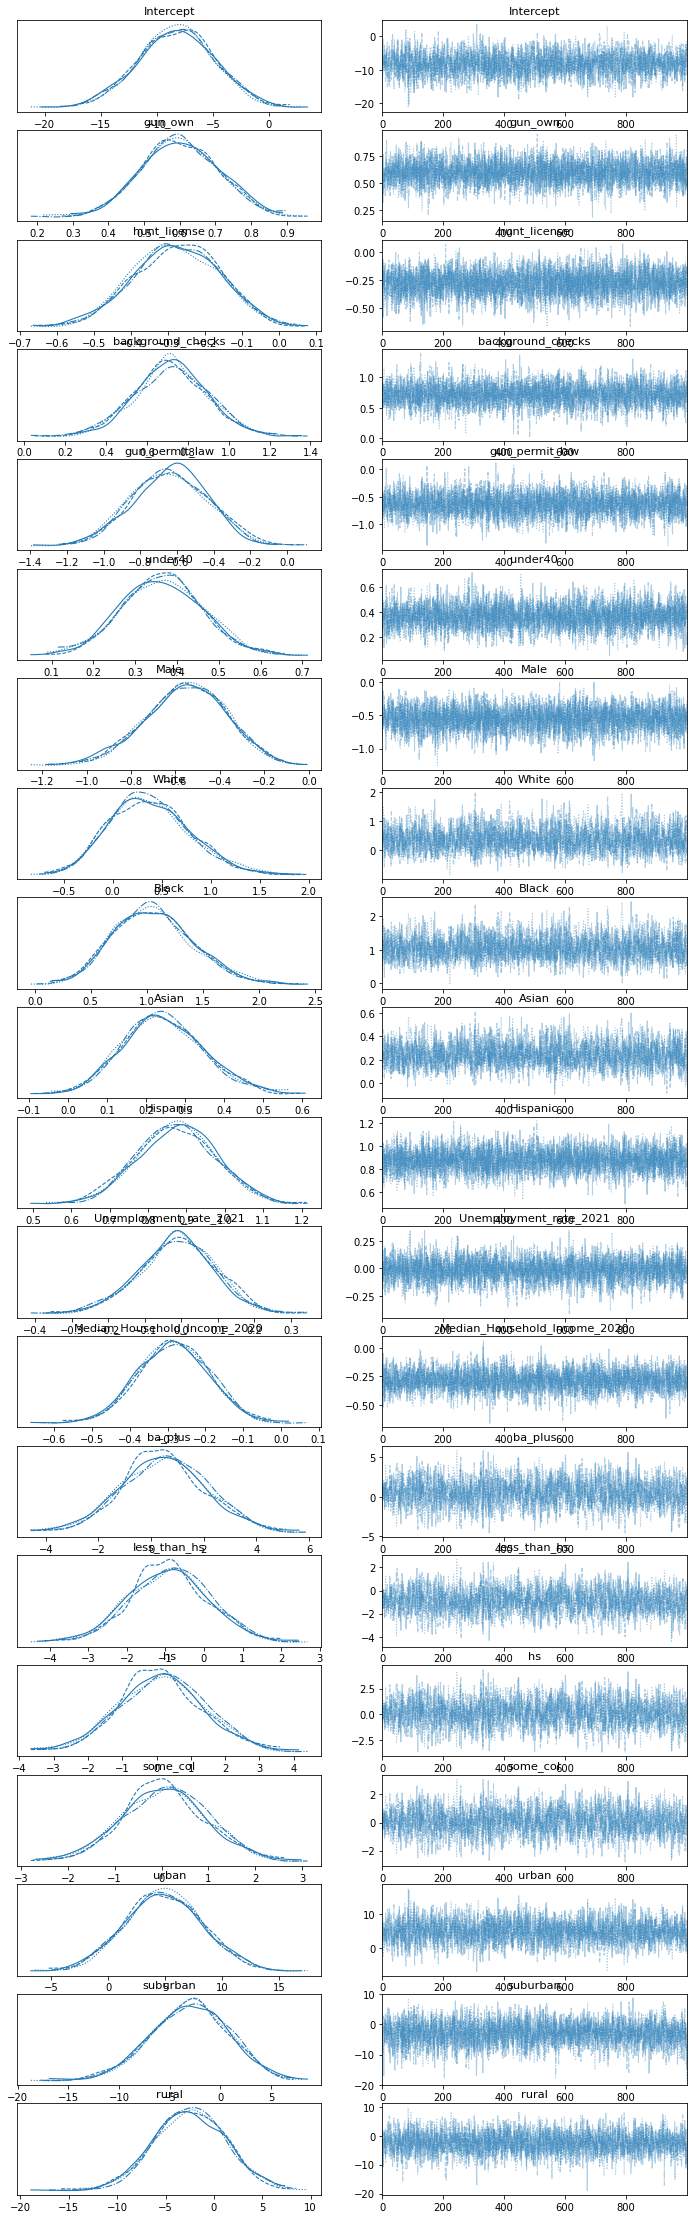

In [19]:
az.plot_trace(inf_fish_alt);

In [20]:
az.summary(np.exp(inf_fish_alt.posterior), kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,0.042,0.682,0.000,0.051
gun_own,1.834,0.200,1.481,2.226
hunt_license,0.762,0.087,0.604,0.925
background_checks,2.083,0.374,1.449,2.835
gun_permit_law,0.540,0.113,0.349,0.755
under40,1.447,0.140,1.189,1.710
Male,0.585,0.103,0.402,0.788
White,1.594,0.730,0.604,2.901
Black,3.090,1.211,1.281,5.218
Asian,1.285,0.134,1.034,1.535


In [41]:
model.posterior_predictive(inf_fish_alt, draws=None)

AttributeError: 'Model' object has no attribute 'posterior_predictive'

In [42]:
az.plot_ppc(inf_fish_alt, num_pp_samples=200);

TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

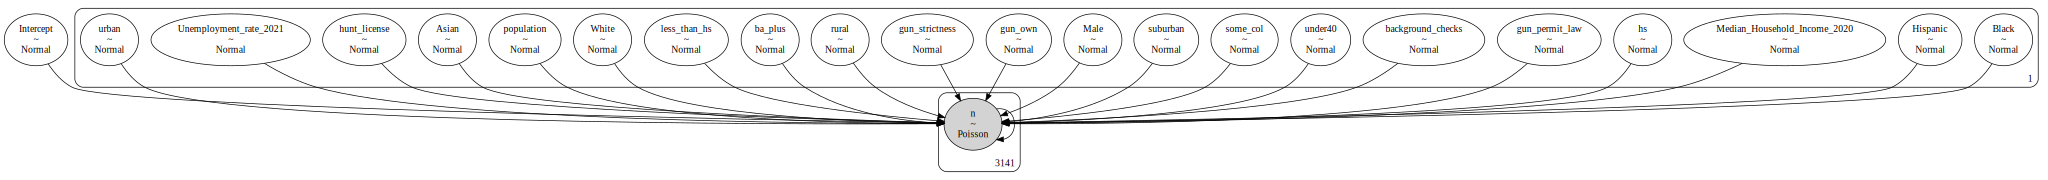

In [21]:
model.graph()

array([[<AxesSubplot:title={'center':'Black'}>,
        <AxesSubplot:title={'center':'Hispanic'}>,
        <AxesSubplot:title={'center':'Median_Household_Income_2020'}>,
        <AxesSubplot:title={'center':'hs'}>],
       [<AxesSubplot:title={'center':'gun_permit_law'}>,
        <AxesSubplot:title={'center':'background_checks'}>,
        <AxesSubplot:title={'center':'under40'}>,
        <AxesSubplot:title={'center':'some_col'}>],
       [<AxesSubplot:title={'center':'suburban'}>,
        <AxesSubplot:title={'center':'Male'}>,
        <AxesSubplot:title={'center':'gun_own'}>,
        <AxesSubplot:title={'center':'gun_strictness'}>],
       [<AxesSubplot:title={'center':'rural'}>,
        <AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'ba_plus'}>,
        <AxesSubplot:title={'center':'less_than_hs'}>],
       [<AxesSubplot:title={'center':'White'}>,
        <AxesSubplot:title={'center':'population'}>,
        <AxesSubplot:title={'center':'Asian'}>,
    

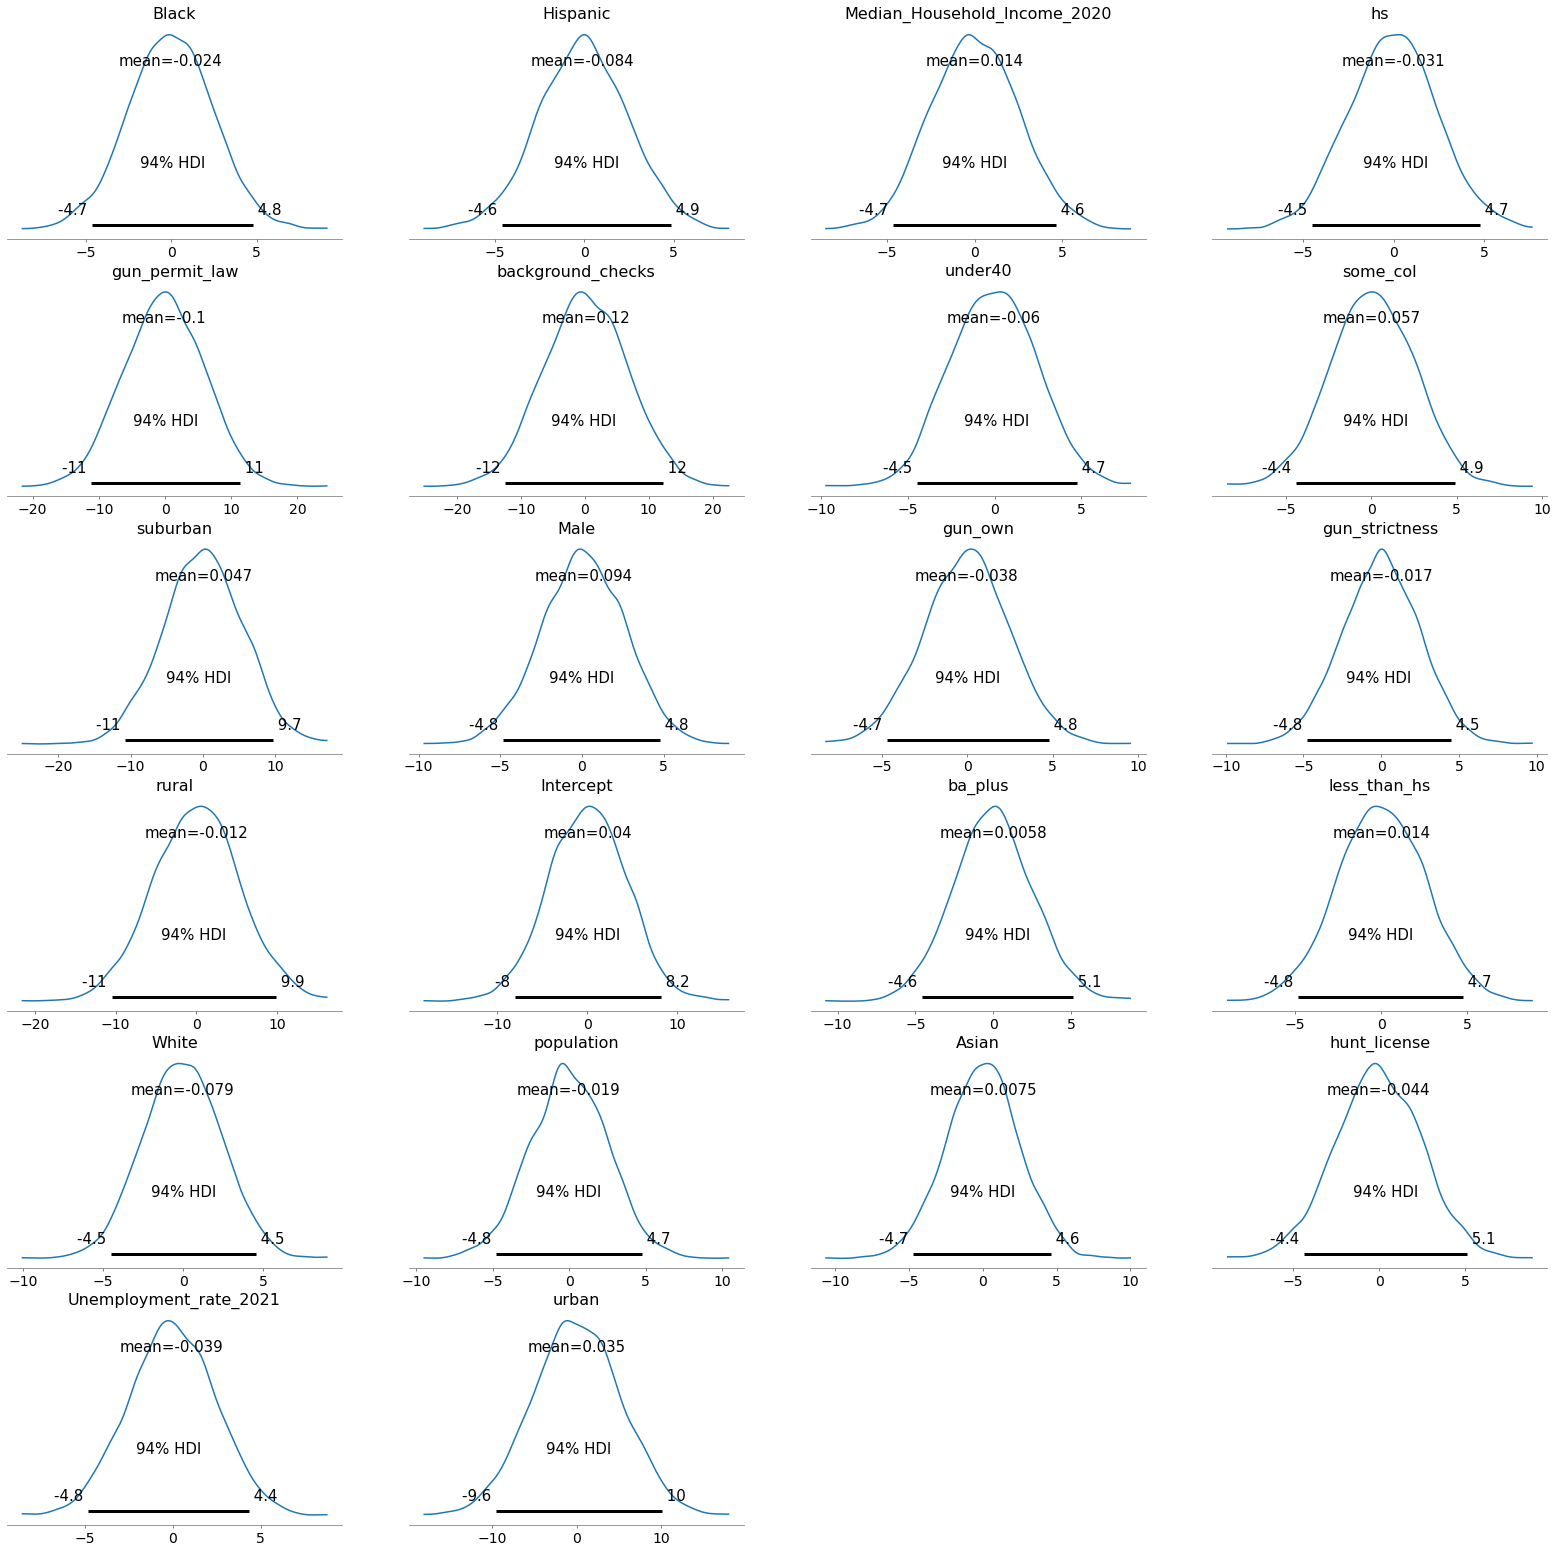

In [22]:
model.plot_priors()